# Prediction model of RRFs of compounds detected by GC/MS

## 0. Conception

*Which decision are we going to inform?* \
We will assist labs by predicting RRFs detected by GC/MS

*What is our prediction estimand?* \
Input data :  Several molecular and physico-chemical characteristics.
The outcome is continuous : Relative Response Factor

*How can you measure the model's success?* \
The model's success will be mostly assessed with the one having the highest R², lowest test MSE. \

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chemistry
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Scikit-learn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import plot_tree
from sklearn.model_selection import KFold, cross_val_predict
from lightgbm import LGBMRegressor


sns.set(style="whitegrid")

# Hyperparameter tuning
import optuna

## 1. Data acquisition

The excel file was created by manually copying the table from the US FDA CLAP list and the table S1 supplementary data from Yun et al.


In [2]:
df = pd.read_excel('processed_data/RRFML.xlsx')

## 2. Exploratory data analysis

In [3]:
df.describe()


DBE           MW          BP       logP  Refractive Index  \
count  92.000000    92.000000   91.000000  92.000000         89.000000   
mean    5.309783   303.179348  359.889011   6.055326          1.523247   
std     4.100953   160.177748  127.047844   4.117937          0.087404   
min     0.000000   102.200000  148.300000  -0.660000          1.289000   
25%     2.000000   195.550000  259.400000   3.142500          1.454000   
50%     4.000000   285.450000  359.400000   5.355000          1.499000   
75%     8.000000   375.600000  435.500000   8.475000          1.585000   
max    20.000000  1177.600000  779.000000  23.000000          1.757000   

         5 µg/mL   10 µg/mL   20 µg/mL  
count  92.000000  92.000000  92.000000  
mean    0.374228   0.406674   0.412489  
std     0.463968   0.484548   0.446450  
min     0.000000   0.000000   0.000000  
25%     0.030250   0.037250   0.053500  
50%     0.207000   0.287000   0.278000  
75%     0.534000   0.527000   0.608500  
max     2.551000   2.143000   1.810000

In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Code               92 non-null     str    
 1   IUPAC name         92 non-null     str    
 2   CAS #              92 non-null     str    
 3   Empirical Formula  92 non-null     str    
 4   DBE                92 non-null     float64
 5   MW                 92 non-null     float64
 6   BP                 91 non-null     float64
 7   pKa                65 non-null     str    
 8   logP               92 non-null     float64
 9   Refractive Index   89 non-null     float64
 10  5 µg/mL            92 non-null     float64
 11  10 µg/mL           92 non-null     float64
 12  20 µg/mL           92 non-null     float64
dtypes: float64(8), str(5)
memory usage: 15.0 KB


## 3. Data preprocessing

We will first convert the CAS number of the extractables into Smiles using pubchem library. This is necessary to get molecular descriptors from the RdKit library.

In [5]:
def get_smiles_from_cas(cas):
    """Utility to fetch SMILES via PubChem"""
    try:
        results = pcp.get_compounds(cas, 'name')
        if results:
            return results[0].smiles
    except Exception as e:
        return None
    return None

df['SMILES'] = df['CAS #'].apply(get_smiles_from_cas)


This CAS number '68515-75-3' was manually added since the automation did not work.

In [6]:
target_cas = '68515-75-3'
manual_smiles = 'CCCCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'

df.loc[df['CAS #'] == target_cas, 'SMILES'] = manual_smiles


We will then convert the Smiles of the extractables into molecular descriptors using rdkit library.

In [7]:
def standardize_and_describe(smiles):
    if not smiles: return None
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    
    try:
        desc_names = [d[0] for d in Descriptors._descList]
        calculator = MoleculeDescriptors.MolecularDescriptorCalculator(desc_names)
        
        vals = calculator.CalcDescriptors(mol)
        return dict(zip(desc_names, vals))
        
    except:
        return None
    
results = df['SMILES'].apply(standardize_and_describe)
results[0]

{'MaxAbsEStateIndex': 14.09759139858905,
 'MaxEStateIndex': 14.09759139858905,
 'MinAbsEStateIndex': 0.06289968406320678,
 'MinEStateIndex': -1.583312103894714,
 'qed': 0.048539300020120885,
 'SPS': 13.176470588235293,
 'MolWt': 1177.6549999999986,
 'HeavyAtomMolWt': 1068.7909999999993,
 'ExactMolWt': 1176.7840788960002,
 'NumValenceElectrons': 472,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.3056426538791839,
 'MinPartialCharge': -0.5073406919509584,
 'MaxAbsPartialCharge': 0.5073406919509584,
 'MinAbsPartialCharge': 0.3056426538791839,
 'FpDensityMorgan1': 0.27058823529411763,
 'FpDensityMorgan2': 0.4,
 'FpDensityMorgan3': 0.5176470588235295,
 'BCUT2D_MWHI': 16.574293698696184,
 'BCUT2D_MWLOW': 9.777866684014993,
 'BCUT2D_CHGHI': 2.3902287655620653,
 'BCUT2D_CHGLO': -2.3165303063670226,
 'BCUT2D_LOGPHI': 2.4427158134677276,
 'BCUT2D_LOGPLOW': -2.4371075753690863,
 'BCUT2D_MRHI': 5.721410186883954,
 'BCUT2D_MRLOW': -0.17026478672952025,
 'AvgIpc': 2.425899834373451,
 'BalabanJ':

Get all predictors into columns instead of dictionary

In [8]:
df_final = df.join(df['SMILES'].apply(standardize_and_describe).apply(pd.Series))

In [9]:
df_final.info()

<class 'pandas.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Columns: 231 entries, Code to fr_urea
dtypes: float64(225), str(6)
memory usage: 175.0 KB


## EDA

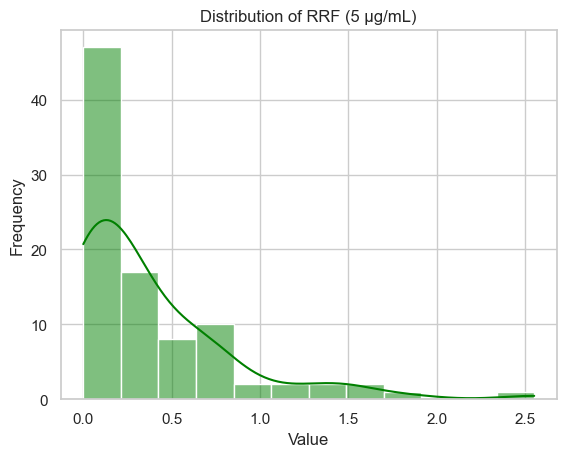

In [10]:
sns.histplot(df_final['5 µg/mL'], kde=True, color='green')
plt.title('Distribution of RRF (5 µg/mL)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

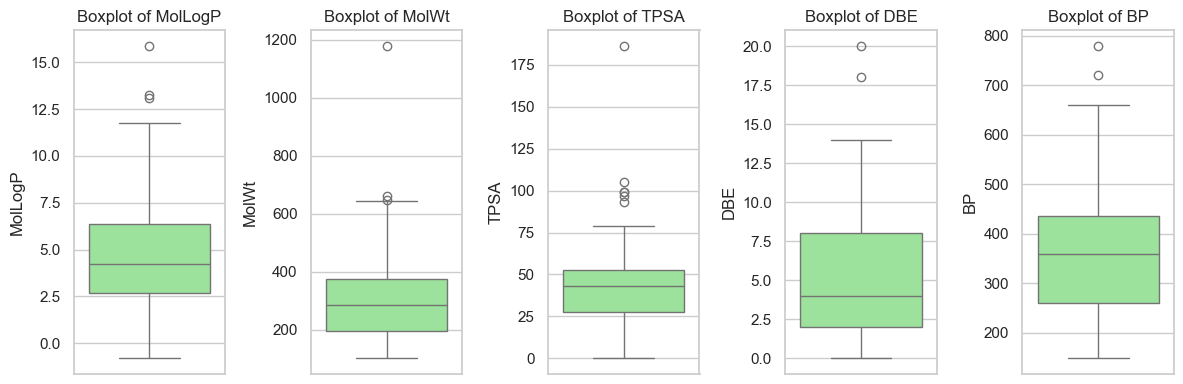

In [11]:
key_desc = ['MolLogP', 'MolWt', 'TPSA', 'DBE', 'BP']

plt.figure(figsize=(12, 4))
for i, col in enumerate(key_desc):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=df_final[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

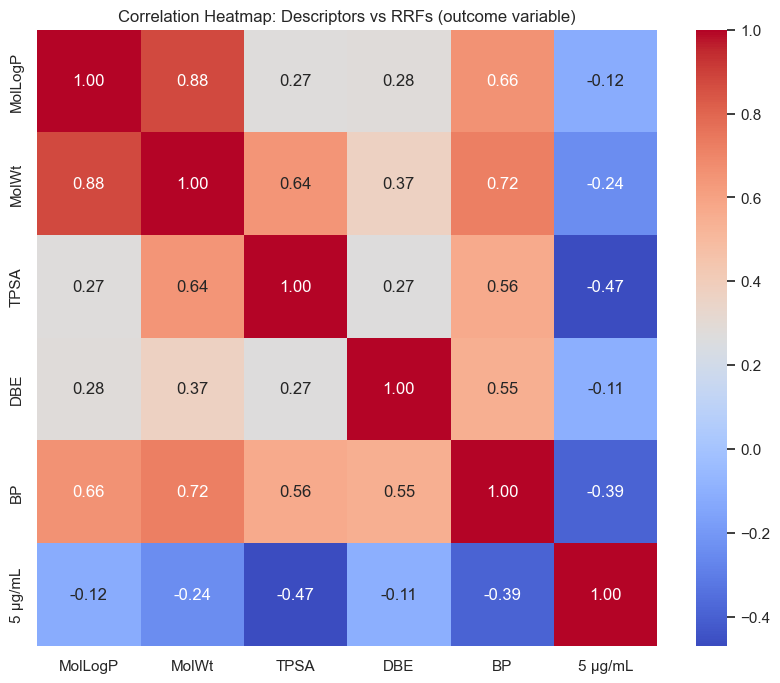

In [12]:
corr_matrix = df_final[key_desc + ['5 µg/mL']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Descriptors vs RRFs (outcome variable)')
plt.show()

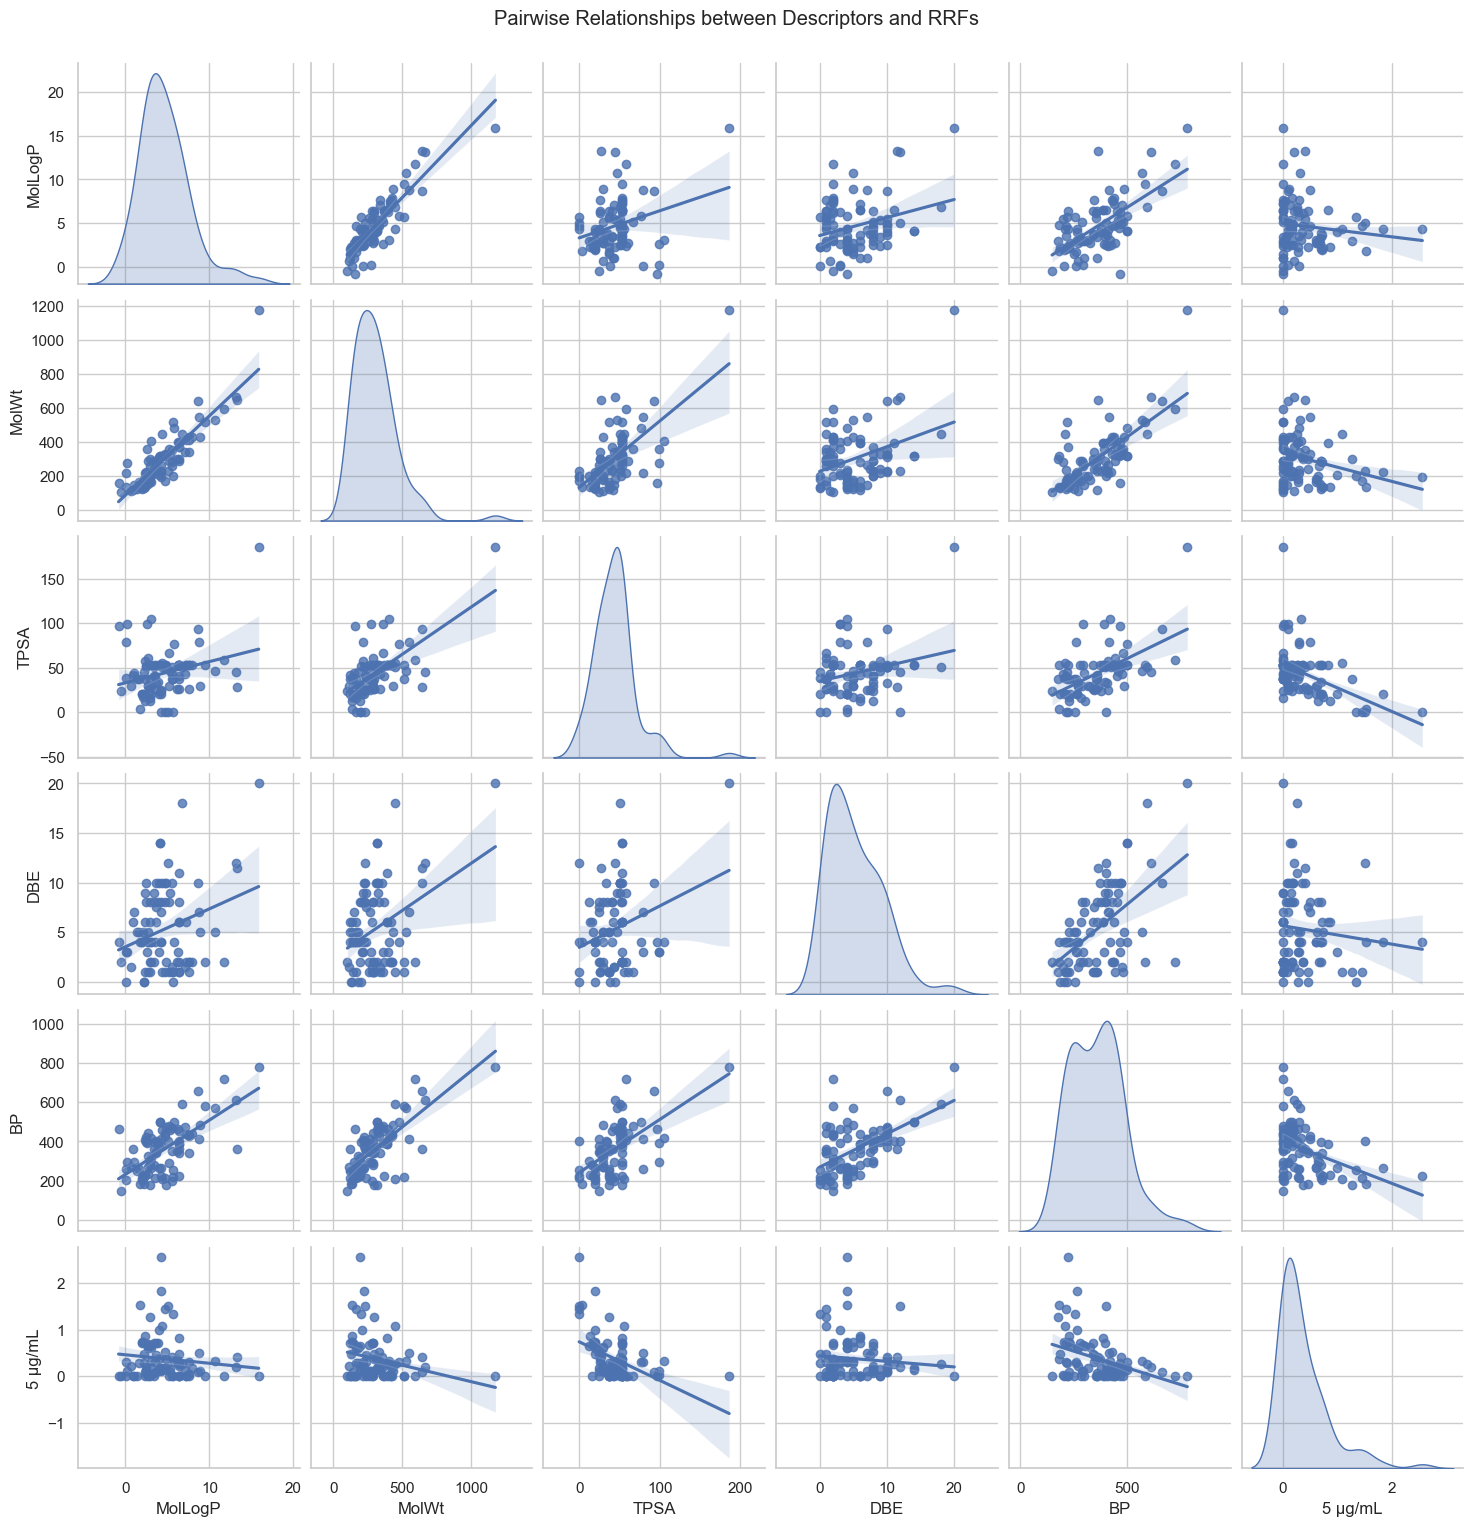

In [13]:
sns.pairplot(df_final, vars=['MolLogP', 'MolWt', 'TPSA', 'DBE', 'BP', '5 µg/mL'], kind='reg', diag_kind='kde')
plt.suptitle('Pairwise Relationships between Descriptors and RRFs', y=1.02)
plt.show()

### Multiple imputation for missing values

I selected relevant descriptors in addition to the ones provided by the CLAP list. Another version exist with all predictors.

In [14]:
missing_data = df_final.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

print(missing_data)


pKa                 27
Refractive Index     3
BP                   1
dtype: int64


Missing values exist for `pKA` (27),  `Refractive Index`(3), `BP`(1).
Values for RI and BP will be imputed using Multiple Imputation. pKA will not be used in the models.

In [15]:
X = df_final.drop(['5 µg/mL', 'IUPAC name', 'CAS #', 'Empirical Formula', '10 µg/mL', '20 µg/mL', 'Code', 'pKa', 'SMILES'] , axis=1) # Features without the 5 µg/mL RRF
y = df_final['5 µg/mL'] # outcome

# Multiple Imputation using IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=42)
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Impute and Scale (for Elastic Net and SVM)
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Keep as DataFrames for feature selection reference
feature_names = X.columns
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)


X_train_sel = X_train_df
X_test_sel = X_test_df

temp_rf = RandomForestRegressor(n_estimators=100, random_state=42)
temp_rf.fit(X_train_df, y_train)
importances = pd.Series(temp_rf.feature_importances_, index=feature_names)
top_20_features = importances.sort_values(ascending=False).head(20).index

X_train_top = X_train_df[top_20_features]
X_test_top = X_test_df[top_20_features]

## 5. Model Selection

As we have a continuous outcome: we will fit three models : \\
Elastic regression (parametric) \\
Random Forests (non-parametric)  \\
Support Vector Machines (non-parametric) \\


## 6. Model training

### ELastic Net Regression

In [16]:
enet = ElasticNet(random_state=42)
enet.fit(X_train_sel, y_train)

ElasticNet(random_state=42)

### Random Forest

In [17]:
RF_model = RandomForestRegressor(n_estimators=100,
                   random_state=42, n_jobs=-1)
RF_model.fit(X_train_top, y_train) 

RandomForestRegressor(n_jobs=-1, random_state=42)

## Gradient Boosting (LGBM)

In [18]:
LGBM_model = LGBMRegressor()
LGBM_model.fit(X_train_top, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] Start training from score 0.399734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMRegressor()

### Support Vector Machine

In [19]:
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_sel, y_train)


SVR()

In [20]:
models = {
    'ElasticNet': enet,
    'Random Forest': RF_model,
    'Gradient Boosting (LGBM)': LGBM_model,
    'SVM': svm_model
}

## 7. Model Evaluation

In [21]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def evaluate_model_cv(model, X, y, model_name="Model"):
    cv_predictions = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    
    cv_r2 = r2_score(y, cv_predictions)
    cv_mae = mean_absolute_error(y, cv_predictions)
    cv_rmse = np.sqrt(mean_squared_error(y, cv_predictions))
    
    print(f"--- {model_name} (k-Fold CV) ---")
    print(f"R²:   {cv_r2:.4f}")
    print(f"MAE:  {cv_mae:.4f}")
    print(f"RMSE: {cv_rmse:.4f}\n")
    
    return cv_predictions

cv_results = {}
for name, model in models.items():
    if name in ['Elastic Net', 'SVM']:
        cv_results[name] = evaluate_model_cv(model, X_train_sel, y_train, name)
    else:
        cv_results[name] = evaluate_model_cv(model, X_train_top, y_train, name)

--- ElasticNet (k-Fold CV) ---
R²:   -0.0139
MAE:  0.3340
RMSE: 0.4691



--- Random Forest (k-Fold CV) ---
R²:   0.4158
MAE:  0.2428
RMSE: 0.3561



--- Gradient Boosting (LGBM) (k-Fold CV) ---
R²:   0.2833
MAE:  0.2664
RMSE: 0.3944

--- SVM (k-Fold CV) ---
R²:   0.4404
MAE:  0.2409
RMSE: 0.3485



## 8. Model optimisation for Random Forest and SVM

Elastic Regression was already optimised during the feature engineering. Therefore, we focus the hyperparameter tuning for RF and SVM.

The strategy is to use a Bayesian optimization (Optuna), to ensure that all parameters will optimise the objective function (maximizing R²)

In [22]:
def objective_svm(trial):
    c = trial.suggest_float('C', 1e-3, 1e2, log=True)
    epsilon = trial.suggest_float('epsilon', 1e-3, 0.5, log=True)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    model = SVR(C=c, epsilon=epsilon, gamma=gamma)
    
    score = cross_val_score(model, X_train_sel, y_train, cv=5, scoring='r2').mean()
    return score

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=30)

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    score = cross_val_score(model, X_train_top, y_train, cv=5, scoring='r2').mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

def objective_lgbm(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMRegressor(**param)
    score = cross_val_score(model, X_train_top, y_train, cv=5, scoring='r2').mean()
    return score

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=50)

[I 2026-02-21 17:08:05,416] A new study created in memory with name: no-name-783c7197-d635-477c-a3e3-f2298f298cbe


[I 2026-02-21 17:08:05,460] Trial 0 finished with value: 0.36156186073806573 and parameters: {'C': 15.019285864530064, 'epsilon': 0.010725231024786973, 'gamma': 'auto'}. Best is trial 0 with value: 0.36156186073806573.


[I 2026-02-21 17:08:05,496] Trial 1 finished with value: 0.35945543220915543 and parameters: {'C': 10.266659293713202, 'epsilon': 0.0015551778338032402, 'gamma': 'auto'}. Best is trial 0 with value: 0.36156186073806573.


[I 2026-02-21 17:08:05,528] Trial 2 finished with value: 0.43235237873795834 and parameters: {'C': 3.191672875195921, 'epsilon': 0.03712254407499501, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,562] Trial 3 finished with value: -0.12342062434765562 and parameters: {'C': 0.002490701141125737, 'epsilon': 0.00473907974723527, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,594] Trial 4 finished with value: 0.3603124195743452 and parameters: {'C': 25.035427236867264, 'epsilon': 0.0084088939624298, 'gamma': 'auto'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,626] Trial 5 finished with value: 0.30344265435729223 and parameters: {'C': 0.2411718576748843, 'epsilon': 0.0014451552391110659, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,658] Trial 6 finished with value: -0.13991947361294751 and parameters: {'C': 0.0013907996211595225, 'epsilon': 0.027118276171353015, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,688] Trial 7 finished with value: -0.09617150413094207 and parameters: {'C': 0.0022768379860242873, 'epsilon': 0.32577929039443293, 'gamma': 'auto'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,720] Trial 8 finished with value: 0.4004969703030977 and parameters: {'C': 2.0055903385624343, 'epsilon': 0.10529055319960764, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,749] Trial 9 finished with value: 0.021148843159906505 and parameters: {'C': 0.05790830094204112, 'epsilon': 0.0010184779260087357, 'gamma': 'auto'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,788] Trial 10 finished with value: 0.39542204348312354 and parameters: {'C': 1.242642978367169, 'epsilon': 0.05743756247064132, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,821] Trial 11 finished with value: 0.3639108638156115 and parameters: {'C': 1.6585844115349906, 'epsilon': 0.1439116978502121, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,857] Trial 12 finished with value: 0.40427453325039886 and parameters: {'C': 2.3456572245758616, 'epsilon': 0.10754891054515439, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,897] Trial 13 finished with value: 0.10729737433534511 and parameters: {'C': 0.08347690784181584, 'epsilon': 0.03369456716685794, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,939] Trial 14 finished with value: -0.4255781459734564 and parameters: {'C': 46.5982072826453, 'epsilon': 0.47713283436440834, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:05,974] Trial 15 finished with value: 0.41922531735117063 and parameters: {'C': 4.033769280274865, 'epsilon': 0.07743461888784633, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,010] Trial 16 finished with value: 0.40655138165131 and parameters: {'C': 82.71359724041739, 'epsilon': 0.056278161102807124, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,050] Trial 17 finished with value: 0.4077170662232216 and parameters: {'C': 6.07514554733382, 'epsilon': 0.013707410668597108, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,084] Trial 18 finished with value: 0.3457098901818349 and parameters: {'C': 0.38490599206804577, 'epsilon': 0.003978356704494766, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,118] Trial 19 finished with value: -0.03896156816702434 and parameters: {'C': 0.01682010617282031, 'epsilon': 0.16751347997339155, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,159] Trial 20 finished with value: 0.35707379457750654 and parameters: {'C': 0.5293847159732261, 'epsilon': 0.04950395517523609, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,200] Trial 21 finished with value: 0.4014376347231717 and parameters: {'C': 6.69481641056695, 'epsilon': 0.016070155324496, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,235] Trial 22 finished with value: 0.42822502100731796 and parameters: {'C': 4.3387728441428255, 'epsilon': 0.014612382088607717, 'gamma': 'scale'}. Best is trial 2 with value: 0.43235237873795834.


[I 2026-02-21 17:08:06,272] Trial 23 finished with value: 0.43328975377607704 and parameters: {'C': 3.699992358613407, 'epsilon': 0.02469863239191378, 'gamma': 'scale'}. Best is trial 23 with value: 0.43328975377607704.


[I 2026-02-21 17:08:06,308] Trial 24 finished with value: 0.38690052407575365 and parameters: {'C': 0.815473267721416, 'epsilon': 0.023604103059307928, 'gamma': 'scale'}. Best is trial 23 with value: 0.43328975377607704.


[I 2026-02-21 17:08:06,340] Trial 25 finished with value: 0.39651424426875825 and parameters: {'C': 29.36035349280172, 'epsilon': 0.005384954978755032, 'gamma': 'scale'}. Best is trial 23 with value: 0.43328975377607704.


[I 2026-02-21 17:08:06,375] Trial 26 finished with value: 0.4218665762596297 and parameters: {'C': 3.5581287981643706, 'epsilon': 0.038593723469868134, 'gamma': 'auto'}. Best is trial 23 with value: 0.43328975377607704.


[I 2026-02-21 17:08:06,419] Trial 27 finished with value: 0.2797599836759447 and parameters: {'C': 0.20442035931709515, 'epsilon': 0.01745291915578893, 'gamma': 'scale'}. Best is trial 23 with value: 0.43328975377607704.


[I 2026-02-21 17:08:06,467] Trial 28 finished with value: 0.397567321366252 and parameters: {'C': 9.947301294724348, 'epsilon': 0.008215285732542372, 'gamma': 'scale'}. Best is trial 23 with value: 0.43328975377607704.


[I 2026-02-21 17:08:06,513] Trial 29 finished with value: 0.39931989330527423 and parameters: {'C': 0.9109123237213459, 'epsilon': 0.01203830389831277, 'gamma': 'auto'}. Best is trial 23 with value: 0.43328975377607704.


[I 2026-02-21 17:08:06,515] A new study created in memory with name: no-name-792ddae8-80e7-455d-b588-65042a2744e7


[I 2026-02-21 17:08:11,320] Trial 0 finished with value: 0.2563263236561471 and parameters: {'n_estimators': 868, 'max_depth': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.2563263236561471.


[I 2026-02-21 17:08:13,585] Trial 1 finished with value: 0.35231626224624063 and parameters: {'n_estimators': 348, 'max_depth': 17, 'min_samples_split': 6}. Best is trial 1 with value: 0.35231626224624063.


[I 2026-02-21 17:08:19,511] Trial 2 finished with value: 0.2533677789472392 and parameters: {'n_estimators': 828, 'max_depth': 2, 'min_samples_split': 12}. Best is trial 1 with value: 0.35231626224624063.


[I 2026-02-21 17:08:26,445] Trial 3 finished with value: 0.37404932961113235 and parameters: {'n_estimators': 936, 'max_depth': 23, 'min_samples_split': 4}. Best is trial 3 with value: 0.37404932961113235.


[I 2026-02-21 17:08:31,353] Trial 4 finished with value: 0.3108747956752452 and parameters: {'n_estimators': 839, 'max_depth': 4, 'min_samples_split': 11}. Best is trial 3 with value: 0.37404932961113235.


[I 2026-02-21 17:08:34,115] Trial 5 finished with value: 0.2970159859590649 and parameters: {'n_estimators': 487, 'max_depth': 26, 'min_samples_split': 15}. Best is trial 3 with value: 0.37404932961113235.


[I 2026-02-21 17:08:35,343] Trial 6 finished with value: 0.2767449861944917 and parameters: {'n_estimators': 228, 'max_depth': 2, 'min_samples_split': 2}. Best is trial 3 with value: 0.37404932961113235.


[I 2026-02-21 17:08:36,475] Trial 7 finished with value: 0.3067261509887571 and parameters: {'n_estimators': 183, 'max_depth': 4, 'min_samples_split': 11}. Best is trial 3 with value: 0.37404932961113235.


[I 2026-02-21 17:08:39,117] Trial 8 finished with value: 0.30346464919679583 and parameters: {'n_estimators': 460, 'max_depth': 18, 'min_samples_split': 13}. Best is trial 3 with value: 0.37404932961113235.


[I 2026-02-21 17:08:39,673] Trial 9 finished with value: 0.28969678806240806 and parameters: {'n_estimators': 98, 'max_depth': 6, 'min_samples_split': 12}. Best is trial 3 with value: 0.37404932961113235.


[I 2026-02-21 17:08:46,222] Trial 10 finished with value: 0.3839958028344808 and parameters: {'n_estimators': 974, 'max_depth': 11, 'min_samples_split': 3}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:08:53,669] Trial 11 finished with value: 0.3816838651069637 and parameters: {'n_estimators': 998, 'max_depth': 11, 'min_samples_split': 2}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:08:58,232] Trial 12 finished with value: 0.35499072571473117 and parameters: {'n_estimators': 677, 'max_depth': 11, 'min_samples_split': 6}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:04,865] Trial 13 finished with value: 0.2864665993058293 and parameters: {'n_estimators': 983, 'max_depth': 10, 'min_samples_split': 20}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:09,905] Trial 14 finished with value: 0.3763670751312092 and parameters: {'n_estimators': 679, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:14,671] Trial 15 finished with value: 0.3462810219937992 and parameters: {'n_estimators': 676, 'max_depth': 14, 'min_samples_split': 7}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:19,854] Trial 16 finished with value: 0.3711225429191072 and parameters: {'n_estimators': 745, 'max_depth': 6, 'min_samples_split': 4}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:25,265] Trial 17 finished with value: 0.34014518094353136 and parameters: {'n_estimators': 985, 'max_depth': 32, 'min_samples_split': 8}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:28,359] Trial 18 finished with value: 0.3554794318558391 and parameters: {'n_estimators': 573, 'max_depth': 4, 'min_samples_split': 4}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:33,072] Trial 19 finished with value: 0.29260389638364187 and parameters: {'n_estimators': 888, 'max_depth': 8, 'min_samples_split': 17}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:37,373] Trial 20 finished with value: 0.32999416479682403 and parameters: {'n_estimators': 792, 'max_depth': 13, 'min_samples_split': 9}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:40,731] Trial 21 finished with value: 0.376079454249275 and parameters: {'n_estimators': 584, 'max_depth': 9, 'min_samples_split': 2}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:44,778] Trial 22 finished with value: 0.3757620394346417 and parameters: {'n_estimators': 710, 'max_depth': 7, 'min_samples_split': 2}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:47,106] Trial 23 finished with value: 0.36876081544283384 and parameters: {'n_estimators': 397, 'max_depth': 13, 'min_samples_split': 5}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:52,194] Trial 24 finished with value: 0.37404740838356365 and parameters: {'n_estimators': 933, 'max_depth': 5, 'min_samples_split': 3}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:56,461] Trial 25 finished with value: 0.36621868974560684 and parameters: {'n_estimators': 767, 'max_depth': 18, 'min_samples_split': 5}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:09:59,818] Trial 26 finished with value: 0.37808179220566884 and parameters: {'n_estimators': 602, 'max_depth': 11, 'min_samples_split': 3}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:10:03,053] Trial 27 finished with value: 0.34547235054202946 and parameters: {'n_estimators': 593, 'max_depth': 12, 'min_samples_split': 7}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:10:04,752] Trial 28 finished with value: 0.3732784731243067 and parameters: {'n_estimators': 283, 'max_depth': 16, 'min_samples_split': 4}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:10:09,649] Trial 29 finished with value: 0.3288509502135151 and parameters: {'n_estimators': 887, 'max_depth': 7, 'min_samples_split': 9}. Best is trial 10 with value: 0.3839958028344808.


[I 2026-02-21 17:10:09,651] A new study created in memory with name: no-name-201d4024-8af0-4868-b6b6-3b135f4556f2


[I 2026-02-21 17:10:09,688] Trial 0 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 1.0519382625719783e-08, 'lambda_l2': 3.394886173449901e-08, 'num_leaves': 58, 'feature_fraction': 0.5352298287428218, 'bagging_fraction': 0.8068723513286261, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 0 with value: -0.1350785240119381.


[I 2026-02-21 17:10:09,728] Trial 1 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 7.543154904580238e-08, 'lambda_l2': 6.519655161993888e-07, 'num_leaves': 100, 'feature_fraction': 0.8124896667681036, 'bagging_fraction': 0.8275226934875085, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 0 with value: -0.1350785240119381.


[I 2026-02-21 17:10:09,798] Trial 2 finished with value: 0.15874796654566248 and parameters: {'lambda_l1': 4.5195038989779235e-07, 'lambda_l2': 0.00012242854765926454, 'num_leaves': 245, 'feature_fraction': 0.8186296990906137, 'bagging_fraction': 0.7376902951385444, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 2 with value: 0.15874796654566248.


[I 2026-02-21 17:10:09,835] Trial 3 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 1.667932674289962, 'lambda_l2': 0.6347236669280601, 'num_leaves': 217, 'feature_fraction': 0.5930409792308485, 'bagging_fraction': 0.8683243503202418, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 2 with value: 0.15874796654566248.


[I 2026-02-21 17:10:09,888] Trial 4 finished with value: 0.2514370858906056 and parameters: {'lambda_l1': 9.522152097183029e-07, 'lambda_l2': 1.1691591251578268, 'num_leaves': 109, 'feature_fraction': 0.6425295485415634, 'bagging_fraction': 0.6676235367043628, 'bagging_freq': 7, 'min_child_samples': 17}. Best is trial 4 with value: 0.2514370858906056.


[I 2026-02-21 17:10:09,928] Trial 5 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 8.106820006621469e-07, 'lambda_l2': 2.943592495331723e-05, 'num_leaves': 117, 'feature_fraction': 0.6660940112783371, 'bagging_fraction': 0.8676735427565555, 'bagging_freq': 4, 'min_child_samples': 44}. Best is trial 4 with value: 0.2514370858906056.


[I 2026-02-21 17:10:09,969] Trial 6 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 0.0024770072060637015, 'lambda_l2': 0.030877944141875908, 'num_leaves': 130, 'feature_fraction': 0.5878527883466659, 'bagging_fraction': 0.5593610054556771, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 4 with value: 0.2514370858906056.


[I 2026-02-21 17:10:10,008] Trial 7 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 9.69880300720679e-06, 'lambda_l2': 4.873837574031423e-05, 'num_leaves': 81, 'feature_fraction': 0.7978117847403874, 'bagging_fraction': 0.4439622967952609, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 4 with value: 0.2514370858906056.


[I 2026-02-21 17:10:10,047] Trial 8 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 0.3393571692424793, 'lambda_l2': 0.007446307884323121, 'num_leaves': 98, 'feature_fraction': 0.4550352080973186, 'bagging_fraction': 0.7308821735234321, 'bagging_freq': 2, 'min_child_samples': 35}. Best is trial 4 with value: 0.2514370858906056.


[I 2026-02-21 17:10:10,086] Trial 9 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 6.003456939126564e-07, 'lambda_l2': 2.1344860025584047e-06, 'num_leaves': 208, 'feature_fraction': 0.5449549006071889, 'bagging_fraction': 0.7474032927480385, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 4 with value: 0.2514370858906056.


[I 2026-02-21 17:10:10,162] Trial 10 finished with value: 0.3167717456093547 and parameters: {'lambda_l1': 0.00031211858876872047, 'lambda_l2': 7.496126487106486, 'num_leaves': 15, 'feature_fraction': 0.9111600554930372, 'bagging_fraction': 0.9713370576738969, 'bagging_freq': 7, 'min_child_samples': 7}. Best is trial 10 with value: 0.3167717456093547.


[I 2026-02-21 17:10:10,225] Trial 11 finished with value: 0.3376509208883377 and parameters: {'lambda_l1': 0.0001568204875689885, 'lambda_l2': 7.789185634042191, 'num_leaves': 2, 'feature_fraction': 0.9913298058035547, 'bagging_fraction': 0.9930688088812853, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 11 with value: 0.3376509208883377.


[I 2026-02-21 17:10:10,302] Trial 12 finished with value: 0.4033651524371096 and parameters: {'lambda_l1': 0.00032963377455548504, 'lambda_l2': 9.509224931466727, 'num_leaves': 4, 'feature_fraction': 0.9710767883435281, 'bagging_fraction': 0.9845768288222424, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 12 with value: 0.4033651524371096.


[I 2026-02-21 17:10:10,363] Trial 13 finished with value: 0.2079544305608319 and parameters: {'lambda_l1': 0.001145719191811143, 'lambda_l2': 0.032752394168773694, 'num_leaves': 4, 'feature_fraction': 0.9910275282458787, 'bagging_fraction': 0.9952264534036871, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 12 with value: 0.4033651524371096.


[I 2026-02-21 17:10:10,430] Trial 14 finished with value: 0.2395373477483588 and parameters: {'lambda_l1': 0.03319087596829172, 'lambda_l2': 4.191322790300098, 'num_leaves': 32, 'feature_fraction': 0.9987192409272994, 'bagging_fraction': 0.9305212867583259, 'bagging_freq': 7, 'min_child_samples': 22}. Best is trial 12 with value: 0.4033651524371096.


[I 2026-02-21 17:10:10,531] Trial 15 finished with value: 0.4312000965720585 and parameters: {'lambda_l1': 6.047865724458633e-05, 'lambda_l2': 0.002601658073669555, 'num_leaves': 157, 'feature_fraction': 0.9152522574052021, 'bagging_fraction': 0.9267299409919714, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:10,586] Trial 16 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 3.0387549033340546e-05, 'lambda_l2': 0.0015826641396932883, 'num_leaves': 163, 'feature_fraction': 0.896411086568282, 'bagging_fraction': 0.9032482641426671, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:10,641] Trial 17 finished with value: -0.11587809931106907 and parameters: {'lambda_l1': 0.03066908147311016, 'lambda_l2': 0.17093941364927479, 'num_leaves': 161, 'feature_fraction': 0.7394558988005547, 'bagging_fraction': 0.6067030603962593, 'bagging_freq': 1, 'min_child_samples': 19}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:10,693] Trial 18 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 1.9060521814624215e-05, 'lambda_l2': 0.0010357018512697042, 'num_leaves': 155, 'feature_fraction': 0.912906009310049, 'bagging_fraction': 0.9237802162781433, 'bagging_freq': 5, 'min_child_samples': 31}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:10,768] Trial 19 finished with value: 0.24226159296893898 and parameters: {'lambda_l1': 0.023380509897638044, 'lambda_l2': 3.992855659273927e-06, 'num_leaves': 192, 'feature_fraction': 0.863018955712072, 'bagging_fraction': 0.7977485562562251, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:10,822] Trial 20 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 0.0038205491101956225, 'lambda_l2': 0.1511394295421915, 'num_leaves': 45, 'feature_fraction': 0.7392894924770295, 'bagging_fraction': 0.4218073165554195, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:10,911] Trial 21 finished with value: 0.38048879750370723 and parameters: {'lambda_l1': 0.00017823833748137813, 'lambda_l2': 7.781291781292222, 'num_leaves': 66, 'feature_fraction': 0.9629440538698171, 'bagging_fraction': 0.9944752344268456, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,006] Trial 22 finished with value: 0.3806054446342141 and parameters: {'lambda_l1': 0.00014831563440462586, 'lambda_l2': 0.959577139200623, 'num_leaves': 69, 'feature_fraction': 0.932335045472417, 'bagging_fraction': 0.9325318895659567, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,068] Trial 23 finished with value: -0.031175612332667458 and parameters: {'lambda_l1': 5.93542828613948e-06, 'lambda_l2': 0.5628205535628976, 'num_leaves': 36, 'feature_fraction': 0.8575088332477186, 'bagging_fraction': 0.935032237262554, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,142] Trial 24 finished with value: 0.20529482550139955 and parameters: {'lambda_l1': 6.142629390298164e-05, 'lambda_l2': 0.01074613981918105, 'num_leaves': 140, 'feature_fraction': 0.9375739470790134, 'bagging_fraction': 0.8640203726788209, 'bagging_freq': 6, 'min_child_samples': 14}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,191] Trial 25 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 0.001312911522958312, 'lambda_l2': 0.09909609313165639, 'num_leaves': 82, 'feature_fraction': 0.8791961253516198, 'bagging_fraction': 0.9469878139509773, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,266] Trial 26 finished with value: 0.2938978549766634 and parameters: {'lambda_l1': 5.5608657412816746e-06, 'lambda_l2': 0.002000272764057028, 'num_leaves': 176, 'feature_fraction': 0.9466816319049867, 'bagging_fraction': 0.8897384084137681, 'bagging_freq': 3, 'min_child_samples': 13}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,328] Trial 27 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 0.008212218315834373, 'lambda_l2': 1.4299314211400558, 'num_leaves': 21, 'feature_fraction': 0.7901162416835013, 'bagging_fraction': 0.8175107024215871, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,412] Trial 28 finished with value: 0.26719298700449007 and parameters: {'lambda_l1': 0.0006996659979975403, 'lambda_l2': 0.3110941180407393, 'num_leaves': 71, 'feature_fraction': 0.8420925761495683, 'bagging_fraction': 0.5194545940331987, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,493] Trial 29 finished with value: 0.23874600104944702 and parameters: {'lambda_l1': 7.312833077488423e-05, 'lambda_l2': 0.00036678318359964864, 'num_leaves': 51, 'feature_fraction': 0.7579572003301759, 'bagging_fraction': 0.7778689758314058, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,551] Trial 30 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 0.2377628814490979, 'lambda_l2': 0.03846522583469444, 'num_leaves': 142, 'feature_fraction': 0.4341484895724298, 'bagging_fraction': 0.6439967118475075, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,649] Trial 31 finished with value: 0.378523334239215 and parameters: {'lambda_l1': 0.00025374835108304554, 'lambda_l2': 2.4914328383352284, 'num_leaves': 66, 'feature_fraction': 0.9518520674543011, 'bagging_fraction': 0.9648062329758886, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,727] Trial 32 finished with value: 0.11182864328760811 and parameters: {'lambda_l1': 0.00012545192349982154, 'lambda_l2': 1.7408082232655875e-08, 'num_leaves': 86, 'feature_fraction': 0.9562112899806976, 'bagging_fraction': 0.9937785467703728, 'bagging_freq': 6, 'min_child_samples': 11}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,801] Trial 33 finished with value: 0.3118793384708428 and parameters: {'lambda_l1': 1.0137057767995419e-07, 'lambda_l2': 2.184405326393895, 'num_leaves': 50, 'feature_fraction': 0.92257285553699, 'bagging_fraction': 0.8507360882105055, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,856] Trial 34 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 2.5791746322824246e-06, 'lambda_l2': 8.263317830787798, 'num_leaves': 255, 'feature_fraction': 0.9663741998336406, 'bagging_fraction': 0.9080886534119318, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:11,931] Trial 35 finished with value: 0.175383496601081 and parameters: {'lambda_l1': 0.0004965456102821916, 'lambda_l2': 0.5287690668054033, 'num_leaves': 119, 'feature_fraction': 0.8209336708383888, 'bagging_fraction': 0.959430274696545, 'bagging_freq': 7, 'min_child_samples': 19}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,014] Trial 36 finished with value: 0.2630514818022435 and parameters: {'lambda_l1': 3.393672442162105e-05, 'lambda_l2': 1.2037740573917337e-07, 'num_leaves': 97, 'feature_fraction': 0.8907613741940232, 'bagging_fraction': 0.8930702797798791, 'bagging_freq': 6, 'min_child_samples': 10}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,073] Trial 37 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 1.0993127903818903e-08, 'lambda_l2': 1.2060347659890993, 'num_leaves': 34, 'feature_fraction': 0.9707413780368765, 'bagging_fraction': 0.8422026889753558, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,131] Trial 38 finished with value: -0.1857149307119929 and parameters: {'lambda_l1': 0.008180159324256921, 'lambda_l2': 0.00562813754895421, 'num_leaves': 67, 'feature_fraction': 0.8273866042557686, 'bagging_fraction': 0.9618962660132775, 'bagging_freq': 5, 'min_child_samples': 26}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,205] Trial 39 finished with value: 0.23297894184216492 and parameters: {'lambda_l1': 2.2706438425197842e-06, 'lambda_l2': 0.06237504889565148, 'num_leaves': 110, 'feature_fraction': 0.671772599243893, 'bagging_fraction': 0.8732715190612723, 'bagging_freq': 6, 'min_child_samples': 17}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,257] Trial 40 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 0.00292676639290807, 'lambda_l2': 3.24024298312494e-05, 'num_leaves': 128, 'feature_fraction': 0.9247783893341046, 'bagging_fraction': 0.9962115608776397, 'bagging_freq': 2, 'min_child_samples': 29}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,354] Trial 41 finished with value: 0.3553563255867255 and parameters: {'lambda_l1': 0.0001678240029023901, 'lambda_l2': 3.0235782740275883, 'num_leaves': 68, 'feature_fraction': 0.9547946692498274, 'bagging_fraction': 0.9634432392552142, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,457] Trial 42 finished with value: 0.39906221970806044 and parameters: {'lambda_l1': 0.0003774258562562144, 'lambda_l2': 1.5052941981329715, 'num_leaves': 63, 'feature_fraction': 0.8759696030374813, 'bagging_fraction': 0.9287115044335632, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,545] Trial 43 finished with value: 0.18254913956302182 and parameters: {'lambda_l1': 1.5891121604016784e-05, 'lambda_l2': 0.29953545613804966, 'num_leaves': 86, 'feature_fraction': 0.8774063236225909, 'bagging_fraction': 0.9229595357652056, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,618] Trial 44 finished with value: 0.2344247011274402 and parameters: {'lambda_l1': 7.798134432505252e-05, 'lambda_l2': 1.1885557603709729, 'num_leaves': 25, 'feature_fraction': 0.9005558379509498, 'bagging_fraction': 0.7119312505595431, 'bagging_freq': 6, 'min_child_samples': 15}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,697] Trial 45 finished with value: 0.27779686712621043 and parameters: {'lambda_l1': 0.0007582980450678925, 'lambda_l2': 9.768008913644953, 'num_leaves': 57, 'feature_fraction': 0.98116244181206, 'bagging_fraction': 0.7825465139863856, 'bagging_freq': 7, 'min_child_samples': 9}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,761] Trial 46 finished with value: -0.1350785240119381 and parameters: {'lambda_l1': 6.813350225363492, 'lambda_l2': 4.0157117960616056, 'num_leaves': 102, 'feature_fraction': 0.791291831960874, 'bagging_fraction': 0.8265992640520687, 'bagging_freq': 6, 'min_child_samples': 36}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,832] Trial 47 finished with value: 0.21887281828135582 and parameters: {'lambda_l1': 0.0003058907094245177, 'lambda_l2': 0.5209936385248028, 'num_leaves': 16, 'feature_fraction': 0.9314328905635522, 'bagging_fraction': 0.9348681255881782, 'bagging_freq': 7, 'min_child_samples': 21}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:12,924] Trial 48 finished with value: 0.25909010836369234 and parameters: {'lambda_l1': 3.963589623099548e-05, 'lambda_l2': 0.00014033698607396447, 'num_leaves': 212, 'feature_fraction': 0.6016877955609409, 'bagging_fraction': 0.8850160929356238, 'bagging_freq': 6, 'min_child_samples': 8}. Best is trial 15 with value: 0.4312000965720585.


[I 2026-02-21 17:10:13,032] Trial 49 finished with value: 0.42927418374559767 and parameters: {'lambda_l1': 0.0014786050390958553, 'lambda_l2': 1.2641815383525211e-05, 'num_leaves': 230, 'feature_fraction': 0.8550085360084805, 'bagging_fraction': 0.9767616397647351, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 15 with value: 0.4312000965720585.


In [23]:
optuna.visualization.plot_optimization_history(study_svm)

In [24]:
optuna.visualization.plot_param_importances(study_svm)


In [25]:
optuna.visualization.plot_optimization_history(study_rf)

In [26]:
optuna.visualization.plot_param_importances(study_rf)

In [27]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [28]:
def plot_model_performance(y_true, y_pred, model_name):
    """
    Generates Predicted vs Actual and Residuals plots
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Predicted vs Actual
    
    axes[0].scatter(y_true, y_pred, alpha=0.6, color='blue', edgecolor='k')
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    axes[0].set_title(f'{model_name}: Predicted vs Actual')
    axes[0].set_xlabel('Actual RRF')
    axes[0].set_ylabel('Predicted RRF')
    axes[0].grid(True)

    # Plot 2: Residuals
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.6, color='purple', edgecolor='k')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    
    axes[1].set_title(f'{model_name}: Residual Plot')
    axes[1].set_xlabel('Predicted RRF')
    axes[1].set_ylabel('Residuals (Actual - Predicted)')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

### Model evaluation on the Optimized Models

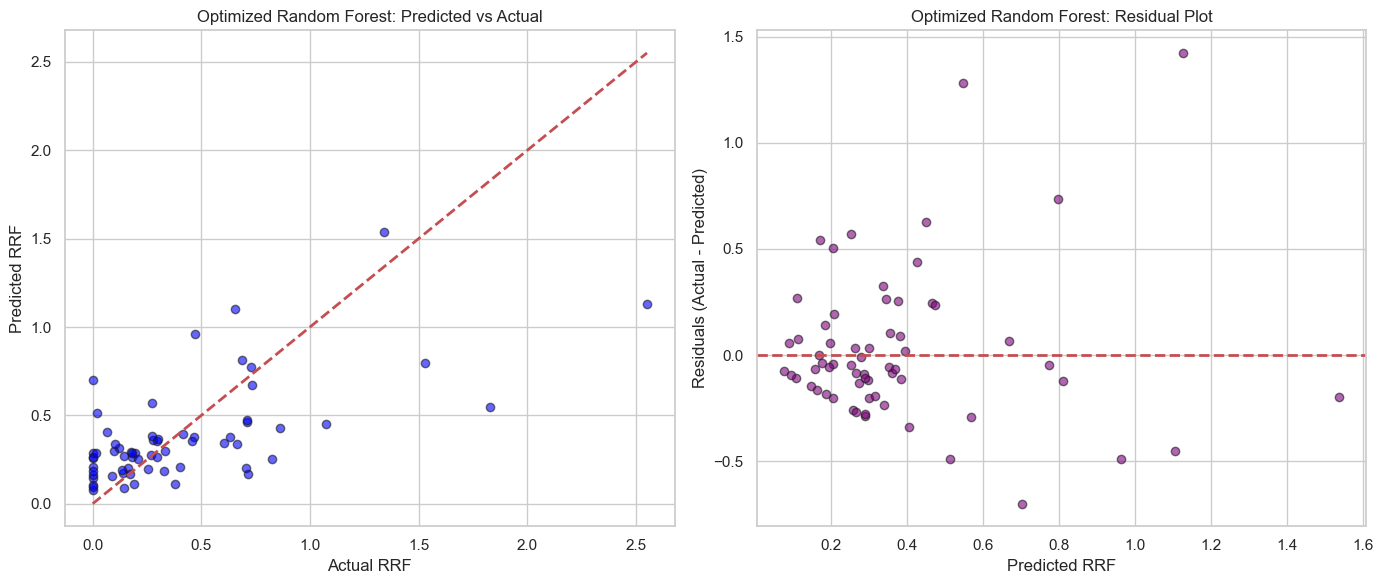

--- Final Optimized RF Metrics ---
CV R²: 0.4032
CV RMSE: 0.3599
--- PERFORMANCE ON HOLD-OUT TEST SET ---
Test R²:   0.6554
Test RMSE: 0.2616


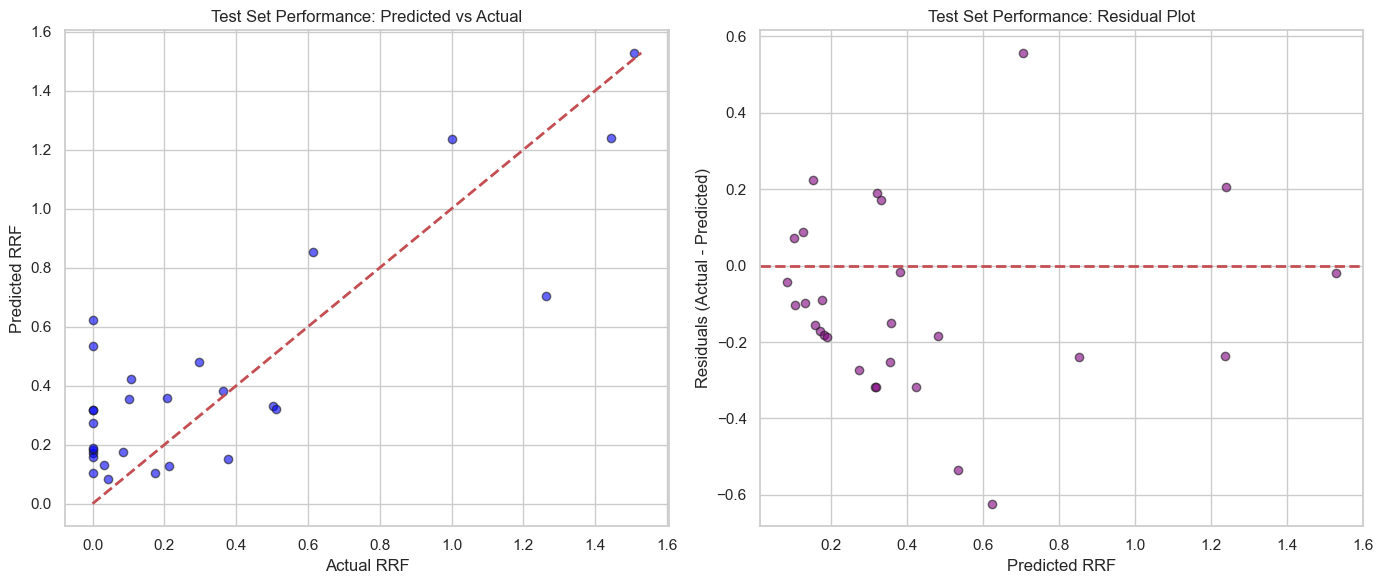

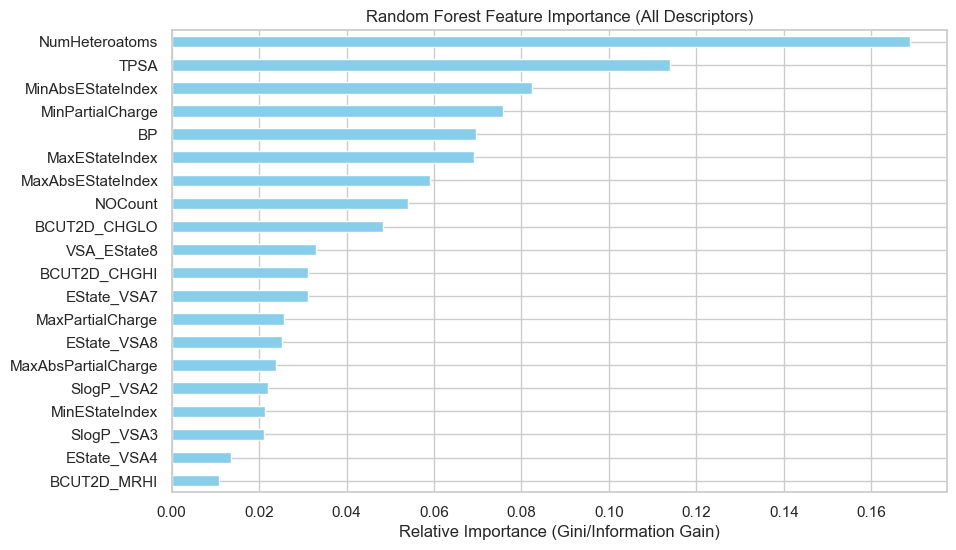

['NumHeteroatoms', 'TPSA', 'MinAbsEStateIndex', 'MinPartialCharge', 'BP', 'MaxEStateIndex', 'MaxAbsEStateIndex', 'NOCount', 'BCUT2D_CHGLO', 'VSA_EState8', 'BCUT2D_CHGHI', 'EState_VSA7', 'MaxPartialCharge', 'EState_VSA8', 'MaxAbsPartialCharge', 'SlogP_VSA2', 'MinEStateIndex', 'SlogP_VSA3', 'EState_VSA4', 'BCUT2D_MRHI']


In [29]:
best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)

best_rf.fit(X_train_top, y_train)

cv_preds_final = cross_val_predict(best_rf, X_train_top, y_train, cv=kf, n_jobs=-1)

plot_model_performance(y_train, cv_preds_final, "Optimized Random Forest")

print("--- Final Optimized RF Metrics ---")
print(f"CV R²: {r2_score(y_train, cv_preds_final):.4f}")
print(f"CV RMSE: {np.sqrt(mean_squared_error(y_train, cv_preds_final)):.4f}")

test_predictions = best_rf.predict(X_test_top)

print("--- PERFORMANCE ON HOLD-OUT TEST SET ---")
print(f"Test R²:   {r2_score(y_test, test_predictions):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

# Optional: Visualize Test Set performance
plot_model_performance(y_test, test_predictions, "Test Set Performance")

importances = best_rf.feature_importances_
feat_importances = pd.Series(importances, index=X_train_top.columns)

plt.figure(figsize=(10, 6))
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh', color='skyblue')
plt.title('Random Forest Feature Importance (All Descriptors)')
plt.xlabel('Relative Importance (Gini/Information Gain)')
plt.show()

selected_features = feat_importances.nlargest(20).index.tolist()
print(selected_features)

# Best LGBM

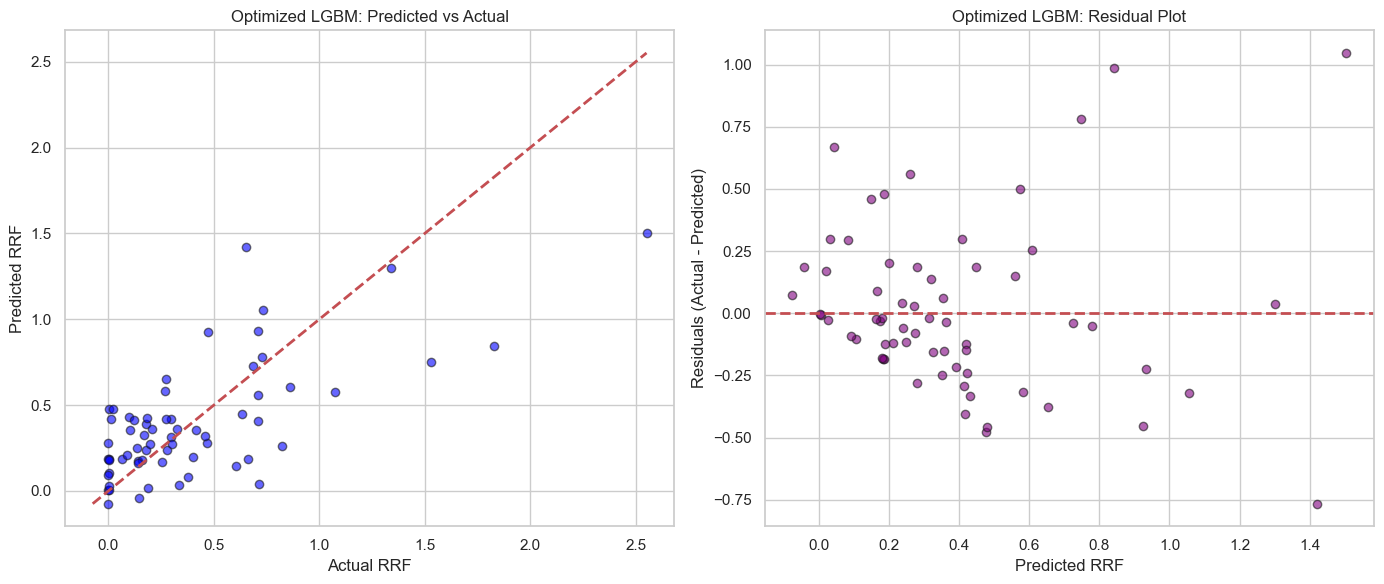

--- Final Optimized LGBM Metrics ---
CV R²: 0.4820
CV RMSE: 0.3353
--- PERFORMANCE ON HOLD-OUT TEST SET ---
Test R²:   0.5391
Test RMSE: 0.3026


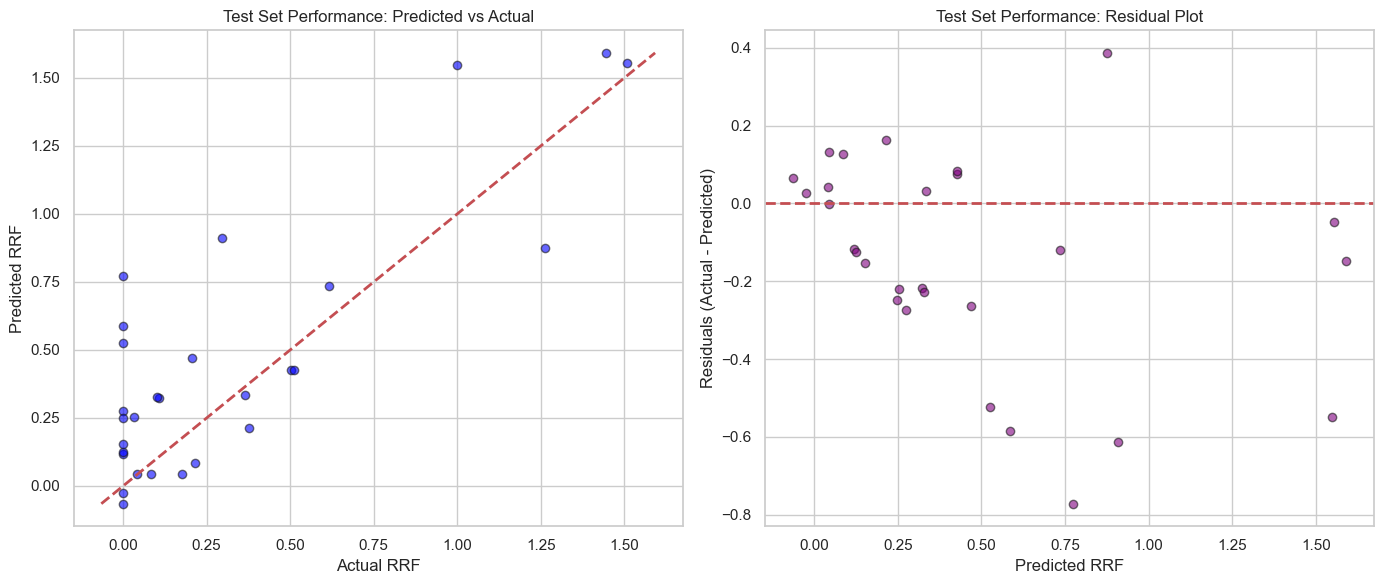

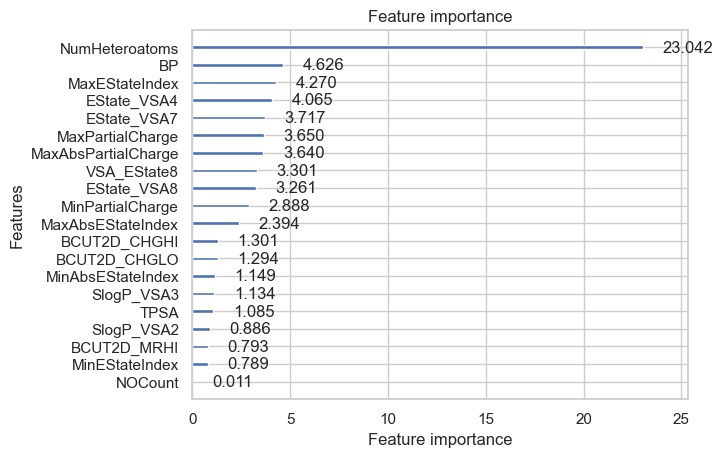

In [30]:
import lightgbm as lgb

best_LGBM = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)

best_LGBM.fit(X_train_top, y_train)

cv_preds_final = cross_val_predict(best_LGBM, X_train_top, y_train, cv=kf, n_jobs=-1)

plot_model_performance(y_train, cv_preds_final, "Optimized LGBM")

print("--- Final Optimized LGBM Metrics ---")
print(f"CV R²: {r2_score(y_train, cv_preds_final):.4f}")
print(f"CV RMSE: {np.sqrt(mean_squared_error(y_train, cv_preds_final)):.4f}")

test_predictions = best_LGBM.predict(X_test_top)

print("--- PERFORMANCE ON HOLD-OUT TEST SET ---")
print(f"Test R²:   {r2_score(y_test, test_predictions):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

# Optional: Visualize Test Set performance
plot_model_performance(y_test, test_predictions, "Test Set Performance")

lgb.plot_importance(best_LGBM, max_num_features=20, importance_type='gain')
plt.show()

importances = best_LGBM.booster_.feature_importance(importance_type='gain')
feature_names = X_train_top.columns
lgbm_feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)



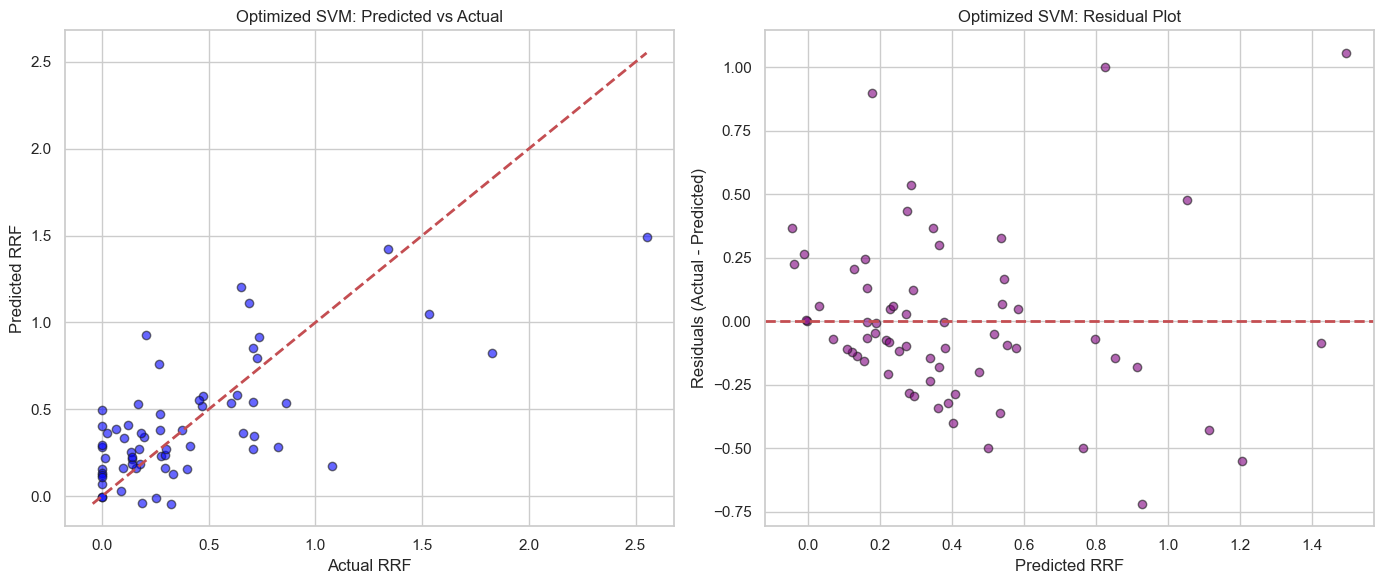

--- Final Optimized RF Metrics ---
CV R²: 0.4911
CV RMSE: 0.3323
--- PERFORMANCE ON HOLD-OUT TEST SET ---
Test R²:   0.6632
Test RMSE: 0.2586


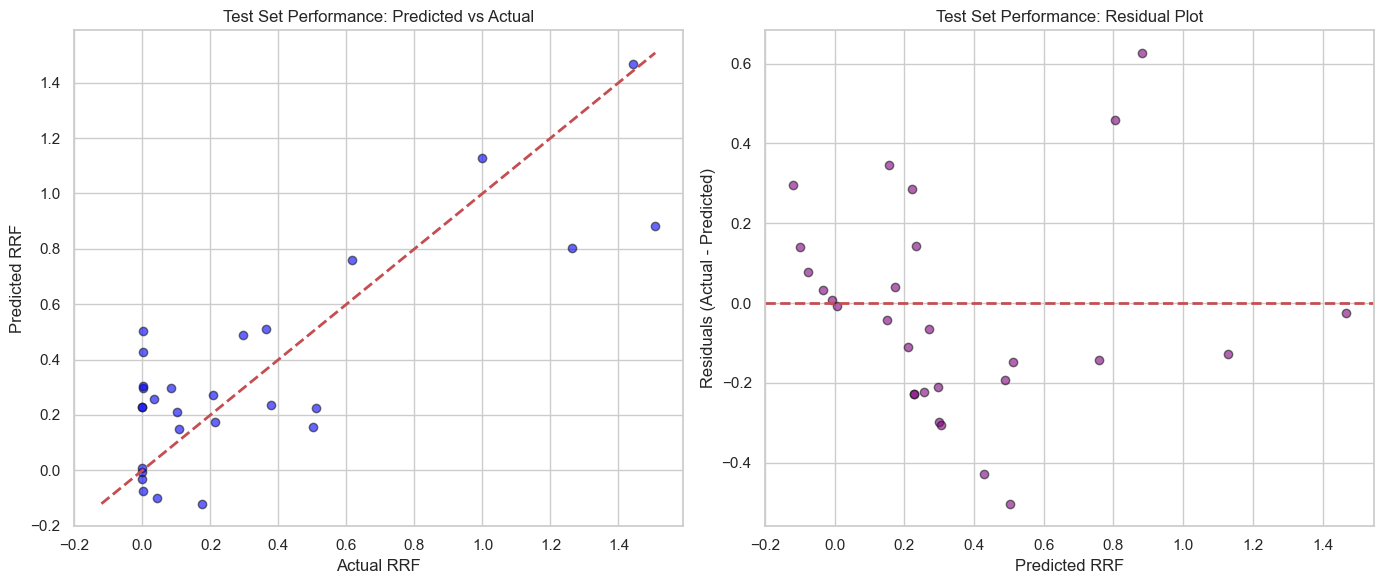

In [31]:
best_svm = SVR(**study_svm.best_params)
               
best_svm.fit(X_train_sel, y_train)

cv_preds_final = cross_val_predict(best_svm, X_train_sel, y_train, cv=kf, n_jobs=-1)

plot_model_performance(y_train, cv_preds_final, "Optimized SVM")

print("--- Final Optimized RF Metrics ---")
print(f"CV R²: {r2_score(y_train, cv_preds_final):.4f}")
print(f"CV RMSE: {np.sqrt(mean_squared_error(y_train, cv_preds_final)):.4f}")

test_predictions = best_svm.predict(X_test_sel)

print("--- PERFORMANCE ON HOLD-OUT TEST SET ---")
print(f"Test R²:   {r2_score(y_test, test_predictions):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")

plot_model_performance(y_test, test_predictions, "Test Set Performance")

## Save the model & the final dataset 

In [32]:
import joblib
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

importances = pd.Series(best_rf.feature_importances_, index=feature_names)
top_20_features_list = list(top_20_features) # Ensure it's a list

# Build pipeline to handle Imputation and Scaling dynamically
final_pipeline = Pipeline([
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1))
])

# Fit on unscaled, raw top 20 features
X_train_raw_top = X_train[top_20_features_list]
final_pipeline.fit(X_train_raw_top, y_train)

joblib.dump(final_pipeline, 'rf_rrf_model_final_20.joblib')
joblib.dump(top_20_features_list, 'features_20.joblib')

df_final.to_csv("final_model_data.csv", index=False)
